# Full Digital-Twin Simulator

Extends the Sionna `End-to-End_Example` by replacing the synthetic hexagonal deployment with the digital-twin scenario generator. The system pipeline (link adaptation, scheduling, PHY abstraction) remains unchanged while BS/UE locations now come from map-based data and ray-tracing hooks.

## Notebook goals
- Load base stations and users from `scenario_generator`
- Run the system-level loop with mobility-driven updates
- Provide a placeholder interface for ray-tracing channels

> Sionna and TensorFlow must be installed in the environment. When running in a fresh Colab runtime, uncomment the installation cell.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = ""  # Use CPU by default; set to index to lock to a specific GPU
    if gpu_num != "":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

try:
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print('Installing Sionna and restarting the runtime. Please run the cell again.')
        os.system('pip install sionna')
        os.kill(os.getpid(), 9)
    else:
        raise e

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)



Using CPU



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

from sionna.phy import config
from sionna.phy.utils import log2, lin_to_db
from sionna.phy.constants import BOLTZMANN_CONSTANT
from phy.mimo import StreamManagement
from phy.ofdm import ResourceGrid, RZFPrecodedChannel, EyePrecodedChannel, LMMSEPostEqualizationSINR

# Backward compatibility for older StreamManagement definitions
if not hasattr(StreamManagement, 'num_streams_per_tx'):
    StreamManagement.num_streams_per_tx = property(lambda self: getattr(self, 'max_streams_per_tx', getattr(self, '_max_streams_per_tx')))
if not hasattr(StreamManagement, 'num_streams_per_rx'):
    StreamManagement.num_streams_per_rx = property(lambda self: getattr(self, 'max_streams_per_rx', getattr(self, '_max_streams_per_rx')))
if not hasattr(StreamManagement, 'num_interfering_streams_per_rx'):
    StreamManagement.num_interfering_streams_per_rx = property(lambda self: getattr(self, 'max_interferers_per_rx', getattr(self, '_max_interferers_per_rx', 0)))
from sionna.sys import PHYAbstraction, OuterLoopLinkAdaptation, PFSchedulerSUMIMO, downlink_fair_power_control, open_loop_uplink_power_control
from sionna.sys.utils import spread_across_subcarriers

from scenario_generator.scenario_main import initialize_scenario_standalone, update_scenario_standalone
from scenario_generator.scenario_config import DEFAULT_MAP_NAME, DEFAULT_RT_NAME, DEFAULT_MAX_POPULATION

# Import for hybrid cluster generation
import pickle
import os
from channel_generator.HybridClusterGenerator import HybridClusterGenerator
from sionna.phy.channel.tr38901 import UMiScenario, LSPGenerator, PanelArray


In [3]:
config.seed = 48
config.precision = 'single'

num_slots = 200  # Number of simulated slots
num_subcarriers = 128
subcarrier_spacing = 30e3
num_ofdm_symbols = 12
carrier_frequency = 3.5e9

temperature = 294.0
no = BOLTZMANN_CONSTANT * temperature * subcarrier_spacing

bler_target = 0.1
mcs_table_index = 1

# num_ut_ant = 1
# num_bs_ant = 8

num_ut_ant = 2
num_bs_ant = 2
num_streams_per_ut = 1

# Global variables for hybrid cluster generation
hybrid_generator = None
rt_params_np = None
los_flag_np = None
lsp_generator = None


## Scenario generator integration
The scenario generator provides mobility traces anchored to a digital-twin map. Base-station locations are loaded from Excel files and user trajectories from the road network.

In [4]:
map_name = DEFAULT_MAP_NAME
rt_name = DEFAULT_RT_NAME
max_population = DEFAULT_MAX_POPULATION

init_response, scenario_state = initialize_scenario_standalone(map_name=map_name, RT_name=rt_name, max_population=max_population)
if scenario_state is None:
    raise RuntimeError(f'Failed to initialize scenario {map_name}')

bs_list = scenario_state.bs_list
users = list(scenario_state.users)
num_bs = len(bs_list)
num_ut = len(users)

print(f"Loaded map '{map_name}' with {num_bs} BS and {num_ut} initial users.")

def _stack_positions_from_bs(bs_objects):
    if not bs_objects:
        return np.zeros((0, 3))
    return np.stack([bs.coordinate.flatten() for bs in bs_objects], axis=0)

def _stack_positions_from_users(user_objects):
    if not user_objects:
        return np.zeros((0, 3))
    return np.stack([user.mobility.coordinate.flatten() for user in user_objects], axis=0)

bs_positions = _stack_positions_from_bs(bs_list)
ue_positions = _stack_positions_from_users(users)

streams_per_tx = int(np.ceil(num_ut / max(1, num_bs)))
streams_per_tx = max(streams_per_tx, num_streams_per_ut)
print(f'Setting {streams_per_tx} spatial stream(s) per transmitter.')

resource_grid_dl = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                                fft_size=num_subcarriers,
                                subcarrier_spacing=subcarrier_spacing,
                                num_tx=num_bs,
                                num_streams_per_tx=streams_per_tx)

resource_grid_ul = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                                fft_size=num_subcarriers,
                                subcarrier_spacing=subcarrier_spacing,
                                num_tx=num_bs,
                                num_streams_per_tx=streams_per_tx)

print(f'Resource grids instantiated with {num_subcarriers} subcarriers x {num_ofdm_symbols} OFDM symbols.')

# Load ray-tracing data and initialize hybrid cluster generator
def load_rt_data_and_init_generator():
    """Load ray-tracing data and initialize hybrid cluster generator"""
    global hybrid_generator, rt_params_np, los_flag_np, lsp_generator
    
    # Load ray-tracing data
    file_path = os.path.join(os.getcwd(), 'channel_generator', 'hybrid_cluster', 'rt_outputs.pkl')
    try:
        with open(file_path, 'rb') as f:
            loaded_data = pickle.load(f)
        
        if isinstance(loaded_data, list) and len(loaded_data) > 0:
            rt_params_raw = loaded_data[0]
            rx_info = loaded_data[1]
        else:
            print("Warning: No ray-tracing data found, using random channels")
            return False
            
    except FileNotFoundError:
        print("Warning: rt_outputs.pkl not found, using random channels")
        return False
    except Exception as e:
        print(f"Warning: Error loading ray-tracing data: {e}, using random channels")
        return False
    
    # Preprocess ray-tracing data
    rt_params_np = {}
    for key, value in rt_params_raw.items():
        tmp_array = np.array(value)
        tmp_array = np.expand_dims(tmp_array, axis=0)
        rt_params_np[key] = tmp_array
    
    # Create los_flag: Set only BS 22 as LOS (matching hybrid_cluster_tester.py)
    tau_first_path = rt_params_np['tau'][:,:,:,0]  # shape: (1, 1, 26)
    los_flag_np = np.zeros_like(tau_first_path, dtype=bool)  # All links NLoS
    los_flag_np[0, 0, 22] = True  # Set only BS 22 as LOS
    
    # Create UMi scenario for LSP generation
    ut_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=2, 
                         polarization="single", polarization_type="V", 
                         antenna_pattern="omni", carrier_frequency=carrier_frequency)
    
    bs_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=1, 
                         polarization="dual", polarization_type="VH", 
                         antenna_pattern="omni", carrier_frequency=carrier_frequency)

    scenario = UMiScenario(carrier_frequency=carrier_frequency, o2i_model="low",
                          ut_array=ut_array, bs_array=bs_array, direction="downlink")
    
    # Initialize LSP generator
    lsp_generator = LSPGenerator(scenario)
    
    # Initialize hybrid cluster generator
    hybrid_generator = HybridClusterGenerator(scenario)
    
    print("Hybrid cluster generator initialized successfully")
    return True

# Initialize hybrid cluster generator
print("Initializing hybrid cluster generator...")
rt_data_loaded = load_rt_data_and_init_generator()
if rt_data_loaded:
    print("✅ SUCCESS: Ray-tracing data loaded successfully. Using realistic channel models.")
    print(f"✅ SUCCESS: rt_params_np shape: {rt_params_np['tau'].shape}")
    print(f"✅ SUCCESS: los_flag_np shape: {los_flag_np.shape}")
    print(f"✅ SUCCESS: Hybrid cluster generator ready for {num_ut} users, {num_bs} BS")
else:
    print("⚠️  WARNING: Ray-tracing data not available. Using random channel models.")



Generated 160 users: 112 pedestrians, 48 vehicles
Successfully loaded 26 BS objects from /home/HJT/Y-Twin/map/map_lists/250312_mobility_map/250312_mobility_map_BS_coord.xlsx
Loaded map '250312_mobility_map' with 26 BS and 160 initial users.
Setting 7 spatial stream(s) per transmitter.
Resource grids instantiated with 128 subcarriers x 12 OFDM symbols.
Initializing hybrid cluster generator...
Hybrid cluster generator initialized successfully
✅ SUCCESS: Ray-tracing data loaded successfully. Using realistic channel models.
✅ SUCCESS: rt_params_np shape: (1, 1, 26, 5)
✅ SUCCESS: los_flag_np shape: (1, 1, 26)
✅ SUCCESS: Hybrid cluster generator ready for 160 users, 26 BS


In [5]:
def build_rx_tx_association_from_h_slot(users, bs_list, h_slot):
    num_ut = len(users)
    num_bs = len(bs_list)
    if num_ut == 0 or num_bs == 0:
        return np.zeros((num_ut, num_bs), dtype=np.float32)

    h_abs2 = tf.math.real(h_slot * tf.math.conj(h_slot))
    power_ut_bs = tf.reduce_mean(h_abs2, axis=[1, 3, 4, 5]).numpy()

    rx_tx = np.zeros((num_ut, num_bs), dtype=np.float32)
    capacity = np.full(num_bs, streams_per_tx, dtype=np.int32)
    ranked_bs = np.argsort(-power_ut_bs, axis=1)

    for ue_idx in range(num_ut):
        assigned = False
        for bs_idx in ranked_bs[ue_idx]:
            if capacity[bs_idx] > 0:
                rx_tx[ue_idx, int(bs_idx)] = 1.0
                capacity[bs_idx] -= 1
                assigned = True
                break
        if not assigned:
            raise RuntimeError('Unable to associate UE within stream capacity constraints.')

    return rx_tx


def users_to_throughput_vector(num_decoded_bits_tensor):
    if num_decoded_bits_tensor is None:
        return []
    per_ut = tf.reduce_sum(num_decoded_bits_tensor, axis=0)
    return per_ut.numpy().astype(np.int64).tolist()


def snapshot_user_coordinates(user_objects):
    return np.stack([user.mobility.coordinate.flatten() for user in user_objects], axis=0) if user_objects else np.zeros((0, 3))


def allocate_power_to_streams(tx_power_per_ut, is_scheduled, stream_management, rx_tx_association):
    tx_power_np = np.asarray(tx_power_per_ut.numpy())
    schedule_np = is_scheduled.numpy()
    batch_size = schedule_np.shape[0]
    if batch_size != 1:
        raise NotImplementedError('Only batch size 1 supported')
    num_ofdm, num_subcarriers, num_ut, num_streams_per_ut = schedule_np.shape[1:]

    def _power_lookup(bs_idx, ut_idx):
        if tx_power_np.ndim == 0:
            return float(tx_power_np)
        if tx_power_np.ndim == 1:
            if ut_idx >= tx_power_np.shape[0]:
                raise IndexError('UT index out of bounds for tx_power vector')
            return float(tx_power_np[ut_idx])
        if tx_power_np.ndim == 2:
            if tx_power_np.shape[0] == stream_management.num_tx:
                return float(tx_power_np[bs_idx, ut_idx])
            if tx_power_np.shape[0] == 1:
                return float(tx_power_np[0, ut_idx])
            if tx_power_np.shape[1] == num_ut:
                return float(tx_power_np.reshape(-1, num_ut)[0, ut_idx])
        raise ValueError('Unsupported tx_power_per_ut shape %s' % (tx_power_np.shape,))

    num_streams_per_tx = getattr(stream_management, 'max_streams_per_tx',
                                 getattr(stream_management, 'num_streams_per_tx',
                                         getattr(stream_management, '_max_streams_per_tx', None)))
    if num_streams_per_tx is None:
        raise AttributeError('StreamManagement object missing stream count metadata')
    result = np.zeros((batch_size,
                       stream_management.num_tx,
                       int(num_streams_per_tx),
                       num_ofdm,
                       num_subcarriers), dtype=tx_power_np.dtype if tx_power_np.size else np.float32)

    allocation_counts = np.sum(schedule_np, axis=(1, 2, 4))
    allocation_counts = np.maximum(allocation_counts, 1.0)
    for ut in range(num_ut):
        serving_bs = np.where(rx_tx_association[ut] > 0)[0]
        if serving_bs.size == 0:
            continue
        bs_idx = int(serving_bs[0])
        stream_info = stream_management.streams_for_tx(bs_idx)
        local_stream = None
        for ls, rx_idx, _ in stream_info:
            if rx_idx == ut:
                local_stream = ls
                break
        if local_stream is None:
            continue
        total_power = _power_lookup(bs_idx, ut)
        if total_power == 0:
            continue
        per_re_power = total_power / allocation_counts[0, ut]
        allocation = schedule_np[0, :, :, ut, :]
        if num_streams_per_ut > 1:
            allocation = np.sum(allocation, axis=-1)
        else:
            allocation = allocation[..., 0]
        result[0, bs_idx, local_stream] += per_re_power * allocation
    return tf.convert_to_tensor(result, dtype=tx_power_per_ut.dtype)



In [6]:
def get_cfr_from_ray_tracing(slot_idx, scenario_state):
    users = scenario_state.users
    bs = scenario_state.bs_list
    num_ut = len(users)
    num_bs = len(bs)
    
    if num_ut == 0 or num_bs == 0:
        return None

    # Create scenario for HybridClusterGenerator
    from sionna.phy.channel.tr38901 import UMiScenario, PanelArray

    ut_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=2,
                          polarization="single", polarization_type="V",
                          antenna_pattern="omni", carrier_frequency=carrier_frequency)

    bs_array = PanelArray(num_rows_per_panel=1, num_cols_per_panel=1,
                          polarization="dual", polarization_type="VH",
                          antenna_pattern="omni", carrier_frequency=carrier_frequency)

    scenario = UMiScenario(carrier_frequency=carrier_frequency, o2i_model="low",
                           ut_array=ut_array, bs_array=bs_array, direction="downlink")

    # Set topology with user and BS locations
    ut_locations = tf.constant([user.mobility.coordinate.flatten() for user in users], dtype=tf.float32)
    bs_locations = tf.constant([bs.coordinate.flatten() for bs in bs], dtype=tf.float32)
    
    # Set all users as outdoor (False for indoor state)
    in_state = tf.zeros([1, num_ut], dtype=tf.bool)  # [batch_size, num_ut]
    
    # Set orientations (default to zero)
    ut_orientations = tf.zeros([1, num_ut, 3], dtype=tf.float32)
    bs_orientations = tf.zeros([1, num_bs, 3], dtype=tf.float32)
    
    # Set velocities (default to zero)
    ut_velocities = tf.zeros([1, num_ut, 3], dtype=tf.float32)
    
    # Set topology
    scenario.set_topology(
        ut_loc=ut_locations[tf.newaxis, ...],  # Add batch dimension
        bs_loc=bs_locations[tf.newaxis, ...],  # Add batch dimension
        in_state=in_state,
        ut_orientations=ut_orientations,
        bs_orientations=bs_orientations,
        ut_velocities=ut_velocities
    )

    # Initialize hybrid generator
    hybrid_gen = HybridClusterGenerator(scenario)

    # Generate channels for each user with pkl path
    h_slot_list = []
    for user_idx, user in enumerate(users):
        pkl_path = getattr(user, 'pkl', None)
            
        if pkl_path is not None:
            # Create individual scenario for this user
            user_scenario = UMiScenario(carrier_frequency=carrier_frequency, o2i_model="low",
                                       ut_array=ut_array, bs_array=bs_array, direction="downlink")
            
            # Set topology for single user
            user_location = tf.constant([user.mobility.coordinate.flatten()], dtype=tf.float32)
            bs_locations = tf.constant([bs.coordinate.flatten() for bs in bs], dtype=tf.float32)
            
            # Set single user as outdoor
            in_state = tf.zeros([1, 1], dtype=tf.bool)  # [batch_size, 1 user]
            
            # Set orientations (default to zero)
            ut_orientations = tf.zeros([1, 1, 3], dtype=tf.float32)
            bs_orientations = tf.zeros([1, num_bs, 3], dtype=tf.float32)
            
            # Set velocities (default to zero)
            ut_velocities = tf.zeros([1, 1, 3], dtype=tf.float32)
            
            # Set topology for single user
            user_scenario.set_topology(
                ut_loc=user_location[tf.newaxis, ...],  # Add batch dimension
                bs_loc=bs_locations[tf.newaxis, ...],  # Add batch dimension
                in_state=in_state,
                ut_orientations=ut_orientations,
                bs_orientations=bs_orientations,
                ut_velocities=ut_velocities
            )
            
            # Create individual hybrid generator for this user
            user_hybrid_gen = HybridClusterGenerator(user_scenario)
            
            # Generate channel for this user
            h_freq, rt_connected_bs = user_hybrid_gen(
                user=user,
                sample_times=tf.range(num_ofdm_symbols, dtype=tf.float32),
                normalize=False,
                num_subcarriers=num_subcarriers,
                subcarrier_spacing=subcarrier_spacing
            )
            # h_freq shape: [B, UT, rx_ant, BS, tx_ant, T, num_subcarriers]
            # [num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers] needed
            h_slot_list.append(h_freq[0, 0, :, :, :, :, :])  # Remove batch and UT dimensions
        else:
            # No pkl path, use random channel
            shape = [num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
            real = tf.random.normal(shape, dtype=tf.float32)
            imag = tf.random.normal(shape, dtype=tf.float32)
            scale = tf.cast(1.0 / np.sqrt(2.0), tf.complex64)
            h_slot_list.append(tf.complex(real, imag) * scale)

    # # DEBUG: Print shapes of all channels before stacking
    # print(f"DEBUG: Total number of users: {len(h_slot_list)}")
    # for i, h_user in enumerate(h_slot_list):
    #     print(f"DEBUG: User {i} channel shape = {h_user.shape}")
    
    # Stack all user channels
    h_slot = tf.stack(h_slot_list, axis=0)  # [num_ut, num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
    return h_slot

In [7]:
def estimate_achievable_rate_from_gain(channel_gain, no):
    rate = log2(tf.cast(1, tf.float32) + channel_gain / no)
    rate = tf.reduce_mean(rate, axis=[-3, -5])
    return tf.transpose(rate, [1, 2, 3, 0])


# Use achievable SINR to estimate rate when feedback is available
def estimate_achievable_rate_from_sinr(sinr_eff, num_ofdm_symbols, num_subcarriers):
    rate = log2(tf.cast(1, tf.float32) + tf.cast(sinr_eff, tf.float32))
    rate = tf.reshape(rate, [tf.shape(rate)[0], 1, 1, tf.shape(rate)[1]])
    rate = tf.tile(rate, [1, num_ofdm_symbols, num_subcarriers, 1])
    return rate


# One downlink slot iteration
def sys_step_downlink(phy_abs_dl, olla_dl, scheduler_dl, h, harq_feedback_dl, sinr_eff_feedback_dl, num_decoded_bits_dl, stream_management, resource_grid, rx_tx_association):
    channel_gain = tf.cast(tf.abs(h)**2, tf.float32)
    rate_gain = estimate_achievable_rate_from_gain(channel_gain, no)
    rate_sinr = estimate_achievable_rate_from_sinr(sinr_eff_feedback_dl, num_ofdm_symbols, num_subcarriers)
    assoc = tf.convert_to_tensor(rx_tx_association, dtype=tf.float32)
    assoc_mask = tf.transpose(assoc)[:, tf.newaxis, tf.newaxis, :]
    rate_est = tf.where(rate_sinr > 0, rate_sinr, rate_gain)
    rate_est = tf.reduce_sum(rate_est * assoc_mask, axis=0, keepdims=True)

    is_scheduled = scheduler_dl(num_decoded_bits_dl, rate_est)
    ut_scheduled = tf.argmax(tf.reduce_sum(tf.cast(is_scheduled, tf.int32), axis=-1), axis=-1)
    num_allocated_re = tf.reduce_sum(tf.cast(is_scheduled, tf.int32), axis=[-4, -3, -1])

    eps = tf.constant(1e-12, dtype=channel_gain.dtype)
    pathloss_matrix = tf.reduce_mean(1.0 / (channel_gain + eps), axis=[1, 3, 4, 5])
    pathloss_per_ut = tf.reduce_sum(pathloss_matrix * assoc, axis=1, keepdims=True)
    pathloss_per_ut = tf.transpose(pathloss_per_ut, [1, 0])

    tx_power_per_ut, _ = downlink_fair_power_control(pathloss_per_ut, no, num_allocated_re)

    tx_power = allocate_power_to_streams(tx_power_per_ut, is_scheduled, stream_management, rx_tx_association)

    h_eff = RZFPrecodedChannel(resource_grid=resource_grid, stream_management=stream_management)(h[tf.newaxis, ...], tx_power=tx_power, alpha=no)
    lmmse = LMMSEPostEqualizationSINR(resource_grid=resource_grid, stream_management=stream_management)
    sinr = lmmse(h_eff, no=no, interference_whitening=True)

    mcs_index = olla_dl(num_allocated_re=num_allocated_re,
                        sinr_eff=sinr_eff_feedback_dl,
                        mcs_table_index=mcs_table_index,
                        mcs_category=1,
                        harq_feedback=harq_feedback_dl)

    num_decoded_bits_dl, harq_feedback_dl, sinr_eff_true, *_ = phy_abs_dl(mcs_index,
                                                                          sinr=sinr,
                                                                          mcs_table_index=mcs_table_index,
                                                                          mcs_category=1,
                                                                          stream_mask=tf.convert_to_tensor(stream_management.rx_stream_mask))
    sinr_eff_db_true = lin_to_db(sinr_eff_true)
    sinr_eff_feedback_dl = tf.where(num_allocated_re > 0, sinr_eff_true, 0)

    return harq_feedback_dl, sinr_eff_feedback_dl, num_decoded_bits_dl, mcs_index, sinr_eff_db_true, ut_scheduled, is_scheduled, tx_power_per_ut


# One uplink slot iteration
def sys_step_uplink(phy_abs_ul, olla_ul, scheduler_ul, h, harq_feedback_ul, sinr_eff_feedback_ul, num_decoded_bits_ul, stream_management, resource_grid, rx_tx_association, alpha_ul=1.0, p0_dbm_ul=-90.0, ut_max_power_dbm=26.0):
    channel_gain = tf.cast(tf.abs(h)**2, tf.float32)
    rate_gain = estimate_achievable_rate_from_gain(channel_gain, no)
    rate_sinr = estimate_achievable_rate_from_sinr(sinr_eff_feedback_ul, num_ofdm_symbols, num_subcarriers)
    assoc = tf.convert_to_tensor(rx_tx_association, dtype=tf.float32)
    assoc_mask = tf.transpose(assoc)[:, tf.newaxis, tf.newaxis, :]
    rate_est = tf.where(rate_sinr > 0, rate_sinr, rate_gain)
    rate_est = tf.reduce_sum(rate_est * assoc_mask, axis=0, keepdims=True)

    is_scheduled = scheduler_ul(num_decoded_bits_ul, rate_est)
    ut_scheduled = tf.argmax(tf.reduce_sum(tf.cast(is_scheduled, tf.int32), axis=-1), axis=-1)
    num_allocated_re = tf.reduce_sum(tf.cast(is_scheduled, tf.int32), axis=[-4, -3, -1])

    eps = tf.constant(1e-12, dtype=channel_gain.dtype)
    pathloss_matrix = tf.reduce_mean(1.0 / (channel_gain + eps), axis=[1, 3, 4, 5])
    pathloss_per_ut = tf.reduce_sum(pathloss_matrix * assoc, axis=1, keepdims=True)
    pathloss_per_ut = tf.transpose(pathloss_per_ut, [1, 0])

    tx_power_per_ut = open_loop_uplink_power_control(pathloss_per_ut,
                                                     num_allocated_re,
                                                     alpha=alpha_ul,
                                                     p0_dbm=p0_dbm_ul,
                                                     ut_max_power_dbm=ut_max_power_dbm)

    tx_power = allocate_power_to_streams(tx_power_per_ut, is_scheduled, stream_management, rx_tx_association)

    h_eff = EyePrecodedChannel(resource_grid=resource_grid, stream_management=stream_management)(h[tf.newaxis, ...], tx_power=tx_power)
    lmmse = LMMSEPostEqualizationSINR(resource_grid=resource_grid, stream_management=stream_management)
    sinr = lmmse(h_eff, no=no, interference_whitening=True)

    mcs_index = olla_ul(num_allocated_re=num_allocated_re,
                        sinr_eff=sinr_eff_feedback_ul,
                        mcs_table_index=mcs_table_index,
                        mcs_category=0,
                        harq_feedback=harq_feedback_ul)

    num_decoded_bits_ul, harq_feedback_ul, sinr_eff_true, *_ = phy_abs_ul(mcs_index,
                                                                          sinr=sinr,
                                                                          mcs_table_index=mcs_table_index,
                                                                          mcs_category=0,
                                                                          stream_mask=tf.convert_to_tensor(stream_management.rx_stream_mask))
    sinr_eff_db_true = lin_to_db(sinr_eff_true)
    sinr_eff_feedback_ul = tf.where(num_allocated_re > 0, sinr_eff_true, 0)

    return harq_feedback_ul, sinr_eff_feedback_ul, num_decoded_bits_ul, mcs_index, sinr_eff_db_true, ut_scheduled, is_scheduled, tx_power_per_ut




In [8]:
def make_sys_objects(num_ut, num_bs):
    phy = PHYAbstraction()
    batch_cfg = [1]
    olla = OuterLoopLinkAdaptation(phy,
                                   num_ut=num_ut,
                                   bler_target=bler_target,
                                   batch_size=batch_cfg)
    scheduler = PFSchedulerSUMIMO(num_ut,
                                  num_subcarriers,
                                  num_ofdm_symbols,
                                  batch_size=batch_cfg,
                                  num_streams_per_ut=num_streams_per_ut,
                                  beta=.9)
    return phy, olla, scheduler



In [9]:
phy_abs_dl, olla_dl, scheduler_dl = make_sys_objects(num_ut, num_bs)
phy_abs_ul, olla_ul, scheduler_ul = make_sys_objects(num_ut, num_bs)

harq_feedback_dl = - tf.ones([1, num_ut], dtype=tf.int32)
sinr_eff_feedback_dl = tf.zeros([1, num_ut], dtype=tf.float32)
num_decoded_bits_dl = tf.zeros([1, num_ut], dtype=tf.int32)

harq_feedback_ul = - tf.ones([1, num_ut], dtype=tf.int32)
sinr_eff_feedback_ul = tf.zeros([1, num_ut], dtype=tf.float32)
num_decoded_bits_ul = tf.zeros([1, num_ut], dtype=tf.int32)


In [11]:
slot_duration_ms = 1

history = {
    'ue_positions': [snapshot_user_coordinates(users)],
    'sinr_dl_db': [],
    'sinr_ul_db': [],
    'mcs_dl': [],
    'mcs_ul': [],
    'scheduled_dl': [],
    'scheduled_ul': [],
    'bits_dl': [],
    'bits_ul': [],
    'tx_power_dl': [],
    'tx_power_ul': [],
}

throughput_bits = [0 for _ in range(num_ut)]
prev_num_ut = num_ut
num_slots = 1
for slot in range(num_slots):
    updated_users_data, scenario_state = update_scenario_standalone(
        scenario_state, time=slot_duration_ms, throughput=throughput_bits)
    users = list(scenario_state.users)

    num_ut = len(users)
    if num_ut == 0:
        print('No active users remaining, stopping early.')
        break

    if num_ut != prev_num_ut:
        phy_abs_dl, olla_dl, scheduler_dl = make_sys_objects(num_ut, num_bs)
        phy_abs_ul, olla_ul, scheduler_ul = make_sys_objects(num_ut, num_bs)
        harq_feedback_dl = - tf.ones([1, num_ut], dtype=tf.int32)
        sinr_eff_feedback_dl = tf.zeros([1, num_ut], dtype=tf.float32)
        num_decoded_bits_dl = tf.zeros([1, num_ut], dtype=tf.int32)
        harq_feedback_ul = - tf.ones([1, num_ut], dtype=tf.int32)
        sinr_eff_feedback_ul = tf.zeros([1, num_ut], dtype=tf.float32)
        num_decoded_bits_ul = tf.zeros([1, num_ut], dtype=tf.int32)
        throughput_bits = [0 for _ in range(num_ut)]

    h_slot = get_cfr_from_ray_tracing(slot, scenario_state)
    if h_slot is None:
        print('Channel generator returned None, skipping slot.')
        continue

    print("✓ Updating h_slot from rt dataset finished")

    rx_tx_association = build_rx_tx_association_from_h_slot(users, bs_list, h_slot)
    # print(rx_tx_association)
    # print(rx_tx_association.shape)
    # print(rx_tx_association[:,25].sum())
    stream_management = StreamManagement(rx_tx_association, num_streams_per_tx=streams_per_tx)

    harq_feedback_dl, sinr_eff_feedback_dl, num_decoded_bits_dl, mcs_dl, sinr_dl_db, ut_scheduled_dl, is_scheduled_dl, tx_power_dl = sys_step_downlink(
        phy_abs_dl,
        olla_dl,
        scheduler_dl,
        h_slot,
        harq_feedback_dl,
        sinr_eff_feedback_dl,
        num_decoded_bits_dl,
        stream_management,
        resource_grid_dl,
        rx_tx_association)

    harq_feedback_ul, sinr_eff_feedback_ul, num_decoded_bits_ul, mcs_ul, sinr_ul_db, ut_scheduled_ul, is_scheduled_ul, tx_power_ul = sys_step_uplink(
        phy_abs_ul,
        olla_ul,
        scheduler_ul,
        h_slot,
        harq_feedback_ul,
        sinr_eff_feedback_ul,
        num_decoded_bits_ul,
        stream_management,
        resource_grid_ul,
        rx_tx_association)

    throughput_bits = users_to_throughput_vector(num_decoded_bits_dl)

    history['ue_positions'].append(snapshot_user_coordinates(users))
    history['sinr_dl_db'].append(np.squeeze(sinr_dl_db.numpy()))
    history['sinr_ul_db'].append(np.squeeze(sinr_ul_db.numpy()))
    history['mcs_dl'].append(np.squeeze(mcs_dl.numpy()))
    history['mcs_ul'].append(np.squeeze(mcs_ul.numpy()))
    history['scheduled_dl'].append(is_scheduled_dl.numpy())
    history['scheduled_ul'].append(is_scheduled_ul.numpy())
    history['bitsdl'].append(num_decoded_bits_dl.numpy())
    history['bits_ul'].append(num_decoded_bits_ul.numpy())
    history['tx_power_dl'].append(tx_power_dl.numpy())
    history['tx_power_ul'].append(tx_power_ul.numpy())

    prev_num_ut = num_ut


✓ Updating h_slot from rt dataset finished


NotImplementedError: Flexible stream management currently supports only single receive-antenna terminals.

## Post-processing

In [ ]:
def _pad_2d_list(arr_list, fill=np.nan):
    if len(arr_list) == 0:
        return None
    processed = [np.atleast_2d(a) for a in arr_list]
    max_bs = max(a.shape[0] for a in processed)
    max_ut = max(a.shape[1] for a in processed)
    out = np.full((len(processed), max_bs, max_ut), fill, dtype=float)
    for t, arr in enumerate(processed):
        out[t, :arr.shape[0], :arr.shape[1]] = arr
    return out




## Results Analysis

In [ ]:

import math

def _stack_slotwise(entries):
    processed = []
    for arr in entries:
        a = np.array(arr)
        a = np.squeeze(a)
        a = np.atleast_1d(a).astype(float)
        processed.append(a)
    if not processed:
        return None
    max_len = max(p.shape[0] for p in processed)
    out = np.full((len(processed), max_len), np.nan, dtype=float)
    for idx_slot, vals in enumerate(processed):
        out[idx_slot, :vals.shape[0]] = vals
    return out

analysis_available = len(history['mcs_dl']) > 0 and len(history['mcs_ul']) > 0

dl_results = {}
ul_results = {}

def _reduce_slotwise(history_sinr, history_mcs, history_bits, history_tx, history_sched):
    sinr_lin, mcs_vals, bits_vals, tx_vals, res_vals = [], [], [], [], []
    for sinr_raw, mcs_raw, bits_raw, tx_raw, sched_raw in zip(history_sinr, history_mcs, history_bits, history_tx, history_sched):
        sinr_arr = np.array(sinr_raw)
        sinr_arr = np.squeeze(sinr_arr)
        sinr_lin_arr = np.power(10.0, sinr_arr/10.0)
        if sinr_lin_arr.ndim >= 3:
            sinr_vec = np.mean(sinr_lin_arr, axis=tuple(range(sinr_lin_arr.ndim-1)))
        elif sinr_lin_arr.ndim == 2:
            sinr_vec = np.array([np.mean(sinr_lin_arr)])
        else:
            sinr_vec = np.atleast_1d(np.mean(sinr_lin_arr))
        sinr_lin.append(np.atleast_1d(sinr_vec).astype(float))

        mcs_vals.append(np.atleast_1d(np.squeeze(mcs_raw)).astype(float))
        bits_vals.append(np.atleast_1d(np.squeeze(bits_raw)).astype(float))
        tx_vals.append(np.atleast_1d(np.squeeze(tx_raw)).astype(float))

        sched_arr = np.array(sched_raw)
        sched_arr = np.squeeze(sched_arr)
        if sched_arr.ndim >= 3:
            re_vec = np.sum(sched_arr, axis=tuple(range(sched_arr.ndim-1)))
        elif sched_arr.ndim == 2:
            re_vec = np.array([np.sum(sched_arr)])
        else:
            re_vec = np.atleast_1d(np.sum(sched_arr))
        res_vals.append(np.atleast_1d(re_vec).astype(float))

    return (_stack_slotwise(sinr_lin),
            _stack_slotwise(mcs_vals),
            _stack_slotwise(bits_vals),
            _stack_slotwise(tx_vals),
            _stack_slotwise(res_vals))

if analysis_available:
    dl_sinr_lin, dl_mcs, dl_bits, dl_tx_watts, dl_res = _reduce_slotwise(
        history['sinr_dl_db'], history['mcs_dl'], history['bits_dl'], history['tx_power_dl'], history['scheduled_dl'])
    ul_sinr_lin, ul_mcs, ul_bits, ul_tx_watts, ul_res = _reduce_slotwise(
        history['sinr_ul_db'], history['mcs_ul'], history['bits_ul'], history['tx_power_ul'], history['scheduled_ul'])

    dl_results = {
        'Effective SINR [dB]': 10*np.log10(np.clip(np.nanmean(dl_sinr_lin, axis=0), 1e-12, None)),
        'MCS': np.nanmean(dl_mcs, axis=0),
        '# decoded bits / slot': np.nanmean(dl_bits, axis=0),
        'TX power [dBm]': 10*np.log10(np.clip(np.nanmean(dl_tx_watts, axis=0), 1e-12, None)) + 30,
        '# allocated RE / slot': np.nanmean(dl_res, axis=0)
    }

    ul_results = {
        'Effective SINR [dB]': 10*np.log10(np.clip(np.nanmean(ul_sinr_lin, axis=0), 1e-12, None)),
        'MCS': np.nanmean(ul_mcs, axis=0),
        '# decoded bits / slot': np.nanmean(ul_bits, axis=0),
        'TX power [dBm]': 10*np.log10(np.clip(np.nanmean(ul_tx_watts, axis=0), 1e-12, None)) + 30,
        '# allocated RE / slot': np.nanmean(ul_res, axis=0)
    }

    total_bits_dl = float(np.nansum(dl_bits))
    total_bits_ul = float(np.nansum(ul_bits))
else:
    total_bits_dl = 0.0
    total_bits_ul = 0.0

print(f"Total DL decoded bits: {total_bits_dl:.0f}")
print(f"Total UL decoded bits: {total_bits_ul:.0f}")

if analysis_available:
    def _summarize(direction, metrics_dict):
        print(f"{direction} summary (per-user averages):")
        for metric in ['Effective SINR [dB]', 'MCS', '# decoded bits / slot', 'TX power [dBm]', '# allocated RE / slot']:
            vals = np.array(metrics_dict[metric])
            vals = vals[~np.isnan(vals)]
            if vals.size:
                print(f"  {metric}: mean={np.mean(vals):.2f}, median={np.median(vals):.2f}, min={np.min(vals):.2f}, max={np.max(vals):.2f}")
        print()

    _summarize('Downlink', dl_results)
    _summarize('Uplink', ul_results)


Total DL decoded bits: 5600
Total UL decoded bits: 5600
Downlink summary (per-user averages):
  Effective SINR [dB]: mean=29.26, median=29.26, min=29.26, max=29.26
  MCS: mean=3.00, median=3.00, min=3.00, max=3.00
  # decoded bits / slot: mean=35.00, median=40.00, min=0.00, max=40.00
  TX power [dBm]: mean=33.73, median=33.66, min=30.95, max=36.67
  # allocated RE / slot: mean=9.60, median=9.00, min=2.00, max=18.00

Uplink summary (per-user averages):
  Effective SINR [dB]: mean=28.73, median=28.73, min=28.73, max=28.73
  MCS: mean=3.00, median=3.00, min=3.00, max=3.00
  # decoded bits / slot: mean=35.00, median=40.00, min=0.00, max=40.00
  TX power [dBm]: mean=-78.27, median=-79.12, min=-81.70, max=-59.57
  # allocated RE / slot: mean=9.60, median=9.00, min=2.00, max=18.00



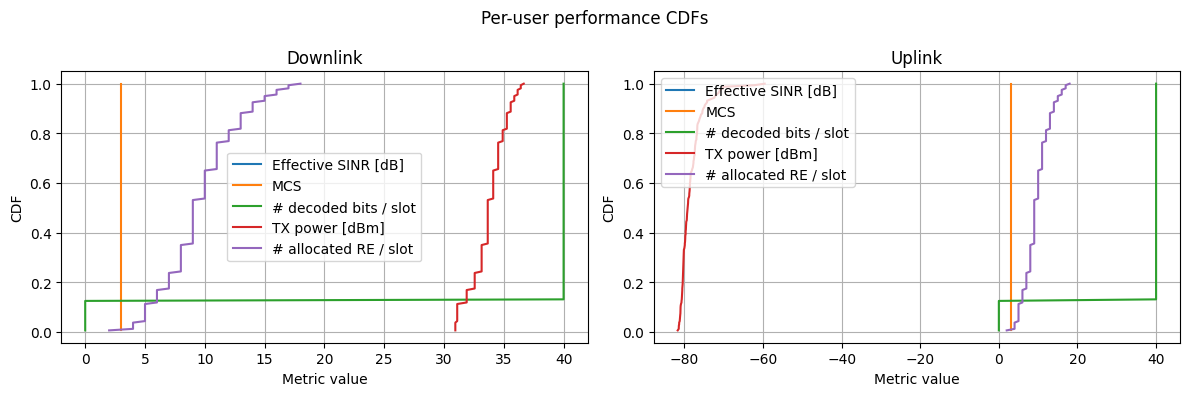

In [ ]:
if analysis_available:
    def get_cdf(values):
        values = np.array(values).flatten()
        values = values[~np.isnan(values)]
        if values.size == 0:
            return np.array([]), np.array([])
        sorted_val = np.sort(values)
        cumulative_prob = np.arange(1, values.size+1) / values.size
        return sorted_val, cumulative_prob

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Per-user performance CDFs')
    for ax, (title, result_dict) in zip(axs, [('Downlink', dl_results), ('Uplink', ul_results)]):
        for metric, values in result_dict.items():
            x, y = get_cdf(values)
            if x.size:
                ax.plot(x, y, label=metric)
        ax.set_title(title)
        ax.set_xlabel('Metric value')
        ax.set_ylabel('CDF')
        ax.grid(True)
        ax.legend()
    plt.tight_layout()

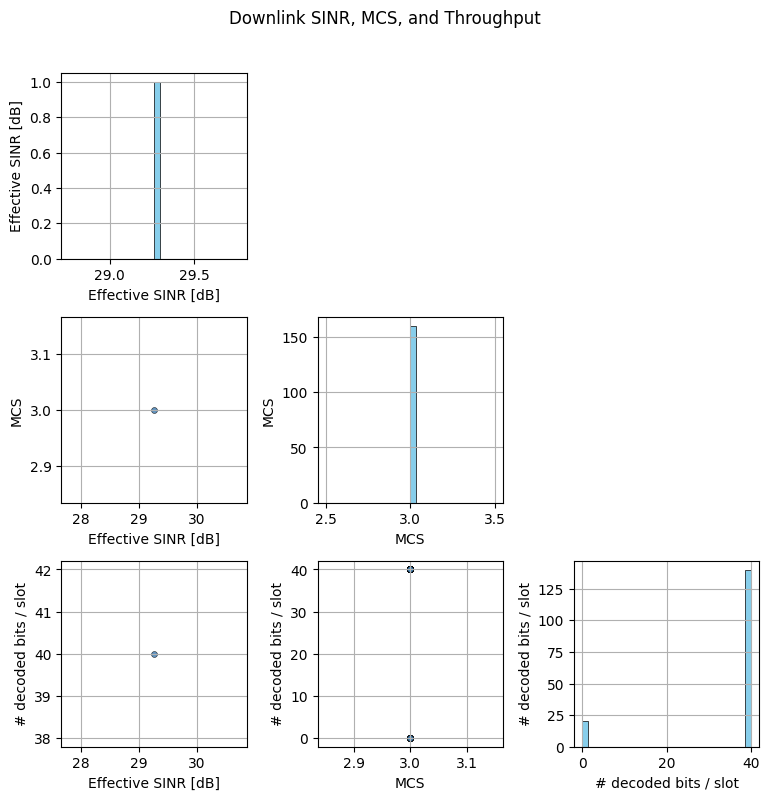

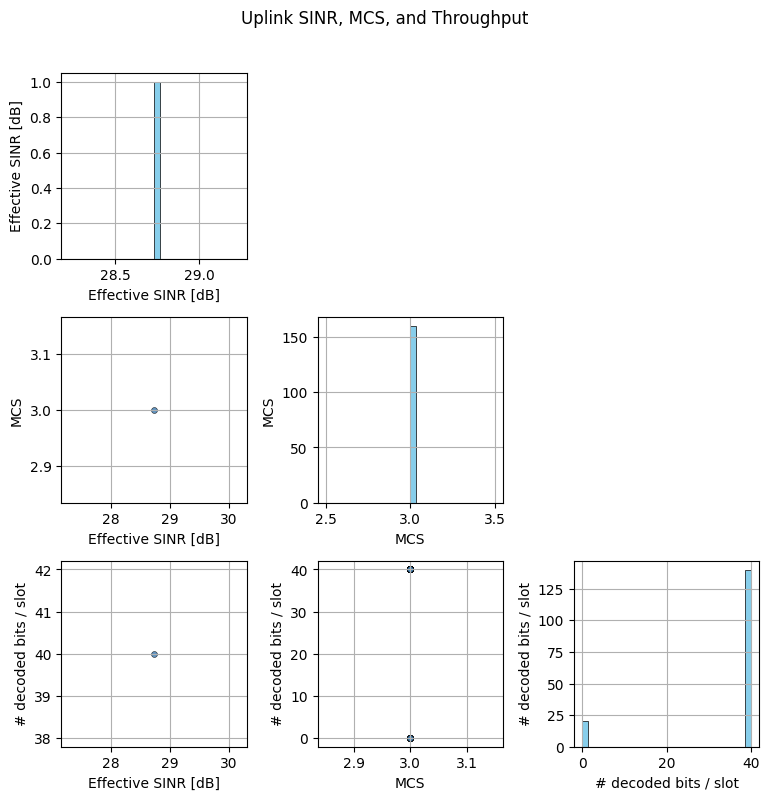

In [ ]:
if analysis_available:
    def pairplot(data_dict, keys, suptitle=None, figsize=2.6):
        fig, axs = plt.subplots(len(keys), len(keys), figsize=[len(keys)*figsize]*2)
        for row, key_row in enumerate(keys):
            for col, key_col in enumerate(keys):
                ax = axs[row, col]
                ax.grid(True)
                vals_row = np.atleast_1d(data_dict[key_row]).astype(float)
                vals_col = np.atleast_1d(data_dict[key_col]).astype(float)
                min_len = min(len(vals_row), len(vals_col))
                if min_len == 0:
                    ax.set_visible(False)
                    continue
                vals_row = vals_row[:min_len]
                vals_col = vals_col[:min_len]
                mask = ~np.isnan(vals_row) if row == col else (~np.isnan(vals_row) & ~np.isnan(vals_col))
                vals_row = vals_row[mask]
                vals_col = vals_col[mask] if row != col else vals_col[mask]
                if row == col:
                    ax.hist(vals_row, bins=30, color='skyblue', edgecolor='k', linewidth=0.5)
                elif col > row:
                    fig.delaxes(ax)
                    continue
                else:
                    ax.scatter(vals_col, vals_row, s=18, color='steelblue', alpha=0.85, linewidths=0.4, edgecolor='k')
                ax.set_xlabel(key_col)
                ax.set_ylabel(key_row)
        if suptitle:
            fig.suptitle(suptitle, y=1.02)
        fig.tight_layout()
        return fig, axs

    dl_keys = ['Effective SINR [dB]', 'MCS', '# decoded bits / slot']
    fig, _ = pairplot(dl_results, dl_keys, suptitle='Downlink SINR, MCS, and Throughput')
    plt.show()

    ul_keys = ['Effective SINR [dB]', 'MCS', '# decoded bits / slot']
    fig, _ = pairplot(ul_results, ul_keys, suptitle='Uplink SINR, MCS, and Throughput')
    plt.show()